In [31]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt

In [32]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='eee-therm')

In [33]:
Map = geemap.Map()
Map.setCenter(-73.05751851170075, 9.023264528918766, 12)

# Define NDVI computation
def add_ndvi(image):
    ndvi = image.expression(
        '((B8 - B4) / (B8 + B4))',
        {
            'B8': image.select('B8'),
            'B4': image.select('B4')
        }
    ).rename('ndvi')
    return image.addBands(ndvi)

# Define NDMI computation
def add_ndmi(image):
    ndmi = image.expression(
        '((B11 - B8A) / (B11 + B8A))',
        {
            'B11': image.select('B11'),
            'B8A': image.select('B8A')
        }
    ).rename('ndmi')
    return image.addBands(ndmi)

# Create function for cloud masking
def mask_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0)
              .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))
    return image.updateMask(mask)

# Create function for shadow, cloud, cirrus, dark areas, snow, and ice masking
def mask_other(image):
    scl = image.select('SCL')
    clear_sky_pixels = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6))
    return image.updateMask(clear_sky_pixels)

def create_feature(row):
    # Parse WKT geometry (assuming 'geometry' column contains WKT)
    wkt = row['geometry']

    # Remove "POLYGON ((" and "))" to extract the coordinates
    wkt = wkt.replace('POLYGON ((', '').replace('))', '')

    # Convert the WKT string into a list of coordinates
    coords = [[float(coord.split()[0]), float(coord.split()[1])] for coord in wkt.split(',')]

    # Create an ee.Geometry.Polygon from the coordinates
    geometry = ee.Geometry.Polygon(coords)

    # Create an ee.Feature using the geometry and any additional attributes (e.g., 'ID' and 'Label')
    feature = ee.Feature(geometry, {'ID': row['ID'], 'Label': row['Label']})

    return feature

def export_polygons_csv(features: list, output_file):
  data = []

  for feature in features:
      # Extract geometry
      polygon_coordinates = feature.geometry().getInfo()['coordinates']
      # Convert polygon coordinates to a Shapely Polygon
      polygon = Polygon(polygon_coordinates[0])  # Assuming the first part of coordinates is the polygon

      # Extract label
      label = feature.get('type').getInfo()

      # Append the feature data to the list
      data.append({'ID': feature.id().getInfo(), 'Label': label, 'geometry': polygon})

  # Create a GeoDataFrame
  gdf = gpd.GeoDataFrame(data, geometry='geometry').to_csv(output_file, index=False)
  print(f"CSV file saved to {output_file}")

def read_ee_polygon(row):
    wkt_str = wkt.loads(row['geometry'])
    polygon_coords = [[[x, y] for x, y in list(wkt_str.exterior.coords)]]
    return ee.Feature(ee.Geometry.Polygon(polygon_coords), properties={'title': row['Label']})

def calculate_mean_reflectance(feature):
    reducer = sentinel_whole_year.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=10
    )
    return feature.set(reducer)

In [34]:
study_area = ee.Geometry.Polygon(
    [[
        [-73.05863431065096, 9.038639089909546],
        [-73.05863431065096, 8.989641653470498],
        [-73.00919583408844, 8.989641653470498],
        [-73.00919583408844, 9.038639089909546]
    ]]
)

sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(study_area) \
    .filterDate('2024-01-01', '2025-01-01') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
    .map(mask_clouds) \
    .map(mask_other) \
    .map(add_ndvi) \
    .map(add_ndmi)


visualization = {
    'min': 440,
    'max': 2000,
    'bands': ['B4', 'B3', 'B2']
}


sentinel_whole_year = sentinel.median().clip(study_area)
print(type(sentinel_whole_year))
Map.addLayer(sentinel, visualization, 'test')

<class 'ee.image.Image'>


In [35]:
df = pd.read_csv('features.csv')
features = list(df.apply(read_ee_polygon, axis=1))
spectral_data = ee.FeatureCollection(list(df.apply(read_ee_polygon, axis=1)))

In [36]:
wavelengths_sentinel = [0.44, 0.50, 0.56, 0.66, 0.70, 0.74, 0.78, 0.84, 0.95, 1.61, 2.20]

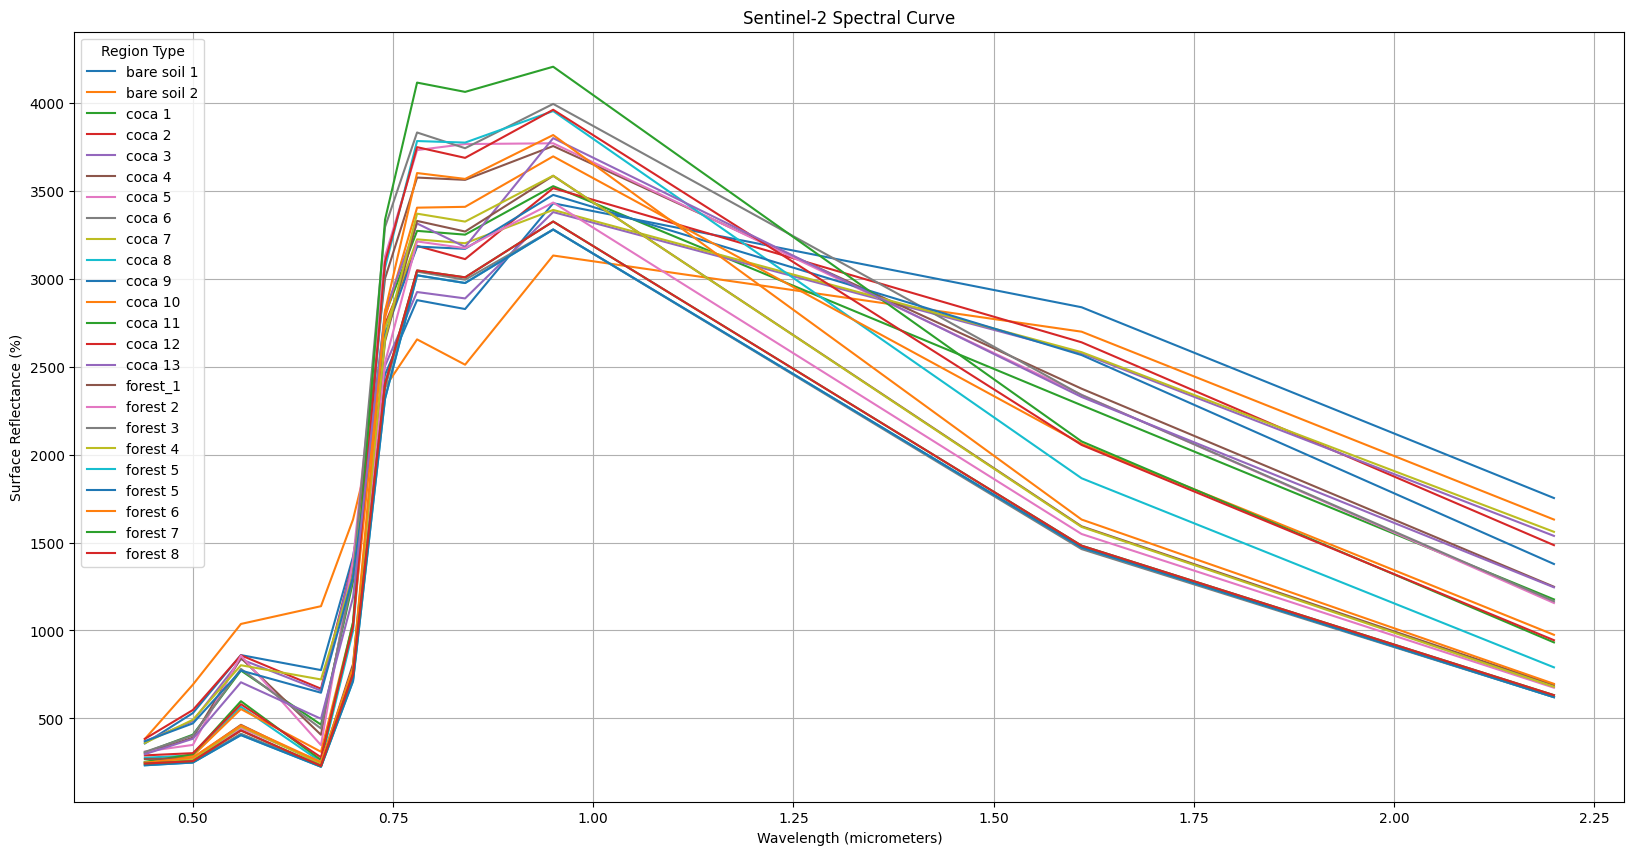

In [37]:

# Apply the function server-side
mean_data = spectral_data.map(calculate_mean_reflectance)

# Fetch the results from the EE server to the local environment
results = mean_data.getInfo()  # Brings data to the client as a dictionary

# Convert results into a DataFrame
df_results = pd.DataFrame([feature['properties'] for feature in results['features']])

# Plot the spectral curves
plt.figure(figsize=(20, 10))

for _, row in df_results.iterrows():
    reflectance_values = [row[band] for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B11', 'B12']]
    plt.plot(wavelengths_sentinel, reflectance_values, label=row.get('title', 'Unknown'))  # 'type' must exist in your data

plt.title('Sentinel-2 Spectral Curve')
plt.xlabel('Wavelength (micrometers)')
plt.ylabel('Surface Reflectance (%)')
plt.legend(title='Region Type')
plt.grid(True)
plt.show()